In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet18
from torchvision.datasets import CIFAR100
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import numpy as np

# 디바이스 설정 (GPU 사용 가능하면 GPU, 아니면 CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def load_data(train_transforms=None, test_transforms=None):
    if train_transforms is None:
        train_transforms = transforms.Compose([
            transforms.Resize(224),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ])
    if test_transforms is None:
        test_transforms = transforms.Compose([
            transforms.Resize(224),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ])
    train_dataset = CIFAR100(root='./data', train=True, download=False, transform=train_transforms)
    test_dataset = CIFAR100(root='./data', train=False, download=False, transform=test_transforms)
    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=4)
    return train_loader, test_loader

def setup_model():
    model = resnet18(pretrained=True)
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, 100)  # CIFAR-100 has 100 classes
    return model.to(device)

def train_model(model, train_loader, criterion, optimizer, num_epochs=60):
    model.train()
    for epoch in tqdm(range(num_epochs)):
        running_loss = 0.0
        correct = 0
        total = 0
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            if batch_idx % 100 == 99:
                print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_loader)}], "
                      f"Loss: {running_loss / 100:.4f}, Accuracy: {100 * correct / total:.2f}%")
                running_loss = 0.0

def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    class_correct = [0] * 100
    class_total = [0] * 100
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            c = (predicted == targets).squeeze()
            for i in range(len(targets)):
                label = targets[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
    overall_accuracy = 100 * correct / total
    class_accuracy = [100 * class_correct[i] / class_total[i] for i in range(100)]
    return overall_accuracy, class_accuracy

def main(train_transforms=None, test_transforms=None):
    train_loader, test_loader = load_data(train_transforms, test_transforms)
    model = setup_model()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1.0e-6)
    train_model(model, train_loader, criterion, optimizer)
    torch.save(model.state_dict(), './model/cifar100_model.pth')  # 모델 저장
    return model

def load_model(filepath):
    model = setup_model()
    model.load_state_dict(torch.load(filepath))
    model.eval()  # 평가 모드로 전환
    return model

In [25]:
# Transformations to test
transformations = {
    "original": transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]),
    "crop": transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]),
    "flip": transforms.Compose([
        transforms.Resize(224),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]),
    "color_jitter": transforms.Compose([
        transforms.Resize(224),
        transforms.ColorJitter(0.8, 0.8, 0.8, 0.2),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]),
    "grayscale": transforms.Compose([
        transforms.Resize(224),
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]),
    "translation": transforms.Compose([
        transforms.Resize(224),
        transforms.RandomAffine(0, translate=(0.1, 0.1)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]),
    "shearing": transforms.Compose([
        transforms.Resize(224),
        transforms.RandomAffine(degrees=0, shear=10),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]),
    "rotation": transforms.Compose([
        transforms.Resize(224),
        transforms.RandomRotation(degrees=180),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]),
    "cutout": transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        transforms.RandomErasing(p=1.0, scale=(0.02, 0.1), ratio=(0.3, 3.3), value='random'),
    ]),
    "noise_injection": transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        transforms.Lambda(lambda img: img + 0.1 * torch.randn_like(img)),
    ]),
    "kernel_filtering": transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        transforms.GaussianBlur(kernel_size=(5, 9), sigma=(9, 11)),
    ]),
    "random_erasing": transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        transforms.RandomErasing(p=1.0, scale=(0.02, 0.1), ratio=(0.3, 3.3), value='random'),
    ]),
}

In [10]:
main()

Files already downloaded and verified
Files already downloaded and verified


/hdd1/iknow/anaconda3/envs/simclr/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/hdd1/iknow/anaconda3/envs/simclr/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [1/60], Batch [100/391], Loss: 4.8733, Accuracy: 1.88%
Epoch [1/60], Batch [200/391], Loss: 4.2787, Accuracy: 2.95%
Epoch [1/60], Batch [300/391], Loss: 4.1113, Accuracy: 3.96%


  2%|▏         | 1/60 [00:44<43:39, 44.40s/it]

Epoch [2/60], Batch [100/391], Loss: 3.8730, Accuracy: 8.42%
Epoch [2/60], Batch [200/391], Loss: 3.7833, Accuracy: 9.54%
Epoch [2/60], Batch [300/391], Loss: 3.6415, Accuracy: 10.67%


  3%|▎         | 2/60 [01:29<43:18, 44.80s/it]

Epoch [3/60], Batch [100/391], Loss: 3.4004, Accuracy: 18.11%
Epoch [3/60], Batch [200/391], Loss: 3.3084, Accuracy: 18.51%
Epoch [3/60], Batch [300/391], Loss: 3.1813, Accuracy: 19.41%


  5%|▌         | 3/60 [02:14<42:47, 45.05s/it]

Epoch [4/60], Batch [100/391], Loss: 2.9447, Accuracy: 26.30%
Epoch [4/60], Batch [200/391], Loss: 2.8881, Accuracy: 26.63%
Epoch [4/60], Batch [300/391], Loss: 2.8289, Accuracy: 27.40%


  7%|▋         | 4/60 [03:00<42:11, 45.21s/it]

Epoch [5/60], Batch [100/391], Loss: 2.6032, Accuracy: 32.84%
Epoch [5/60], Batch [200/391], Loss: 2.5588, Accuracy: 33.30%
Epoch [5/60], Batch [300/391], Loss: 2.4737, Accuracy: 34.09%


  8%|▊         | 5/60 [03:45<41:31, 45.31s/it]

Epoch [6/60], Batch [100/391], Loss: 2.2922, Accuracy: 39.88%
Epoch [6/60], Batch [200/391], Loss: 2.2925, Accuracy: 40.02%
Epoch [6/60], Batch [300/391], Loss: 2.2398, Accuracy: 40.38%


 10%|█         | 6/60 [04:31<40:48, 45.35s/it]

Epoch [7/60], Batch [100/391], Loss: 2.0053, Accuracy: 46.35%
Epoch [7/60], Batch [200/391], Loss: 2.0524, Accuracy: 45.75%
Epoch [7/60], Batch [300/391], Loss: 2.0093, Accuracy: 45.76%


 12%|█▏        | 7/60 [05:16<40:03, 45.36s/it]

Epoch [8/60], Batch [100/391], Loss: 1.8071, Accuracy: 50.82%
Epoch [8/60], Batch [200/391], Loss: 1.8595, Accuracy: 49.95%
Epoch [8/60], Batch [300/391], Loss: 1.8422, Accuracy: 49.82%


 13%|█▎        | 8/60 [06:01<39:18, 45.36s/it]

Epoch [9/60], Batch [100/391], Loss: 1.6492, Accuracy: 54.19%
Epoch [9/60], Batch [200/391], Loss: 1.6528, Accuracy: 54.20%
Epoch [9/60], Batch [300/391], Loss: 1.6864, Accuracy: 53.88%


 15%|█▌        | 9/60 [06:47<38:33, 45.36s/it]

Epoch [10/60], Batch [100/391], Loss: 1.4768, Accuracy: 58.41%
Epoch [10/60], Batch [200/391], Loss: 1.5430, Accuracy: 57.53%
Epoch [10/60], Batch [300/391], Loss: 1.5322, Accuracy: 57.41%


 17%|█▋        | 10/60 [07:32<37:48, 45.37s/it]

Epoch [11/60], Batch [100/391], Loss: 1.3584, Accuracy: 61.43%
Epoch [11/60], Batch [200/391], Loss: 1.3800, Accuracy: 61.18%
Epoch [11/60], Batch [300/391], Loss: 1.4195, Accuracy: 60.86%


 18%|█▊        | 11/60 [08:18<37:03, 45.37s/it]

Epoch [12/60], Batch [100/391], Loss: 1.1815, Accuracy: 66.12%
Epoch [12/60], Batch [200/391], Loss: 1.2726, Accuracy: 64.86%
Epoch [12/60], Batch [300/391], Loss: 1.3381, Accuracy: 63.79%


 20%|██        | 12/60 [09:03<36:18, 45.38s/it]

Epoch [13/60], Batch [100/391], Loss: 1.1021, Accuracy: 68.09%
Epoch [13/60], Batch [200/391], Loss: 1.1321, Accuracy: 67.62%
Epoch [13/60], Batch [300/391], Loss: 1.1973, Accuracy: 66.87%


 22%|██▏       | 13/60 [09:48<35:32, 45.37s/it]

Epoch [14/60], Batch [100/391], Loss: 0.9700, Accuracy: 71.66%
Epoch [14/60], Batch [200/391], Loss: 1.0302, Accuracy: 70.66%
Epoch [14/60], Batch [300/391], Loss: 1.0733, Accuracy: 69.72%


 23%|██▎       | 14/60 [10:34<34:45, 45.34s/it]

Epoch [15/60], Batch [100/391], Loss: 0.8544, Accuracy: 74.75%
Epoch [15/60], Batch [200/391], Loss: 0.9231, Accuracy: 73.72%
Epoch [15/60], Batch [300/391], Loss: 0.9951, Accuracy: 72.62%


 25%|██▌       | 15/60 [11:19<34:00, 45.34s/it]

Epoch [16/60], Batch [100/391], Loss: 0.7479, Accuracy: 77.82%
Epoch [16/60], Batch [200/391], Loss: 0.8162, Accuracy: 76.46%
Epoch [16/60], Batch [300/391], Loss: 0.8871, Accuracy: 75.13%


 27%|██▋       | 16/60 [12:04<33:14, 45.34s/it]

Epoch [17/60], Batch [100/391], Loss: 0.6520, Accuracy: 80.84%
Epoch [17/60], Batch [200/391], Loss: 0.7236, Accuracy: 79.34%
Epoch [17/60], Batch [300/391], Loss: 0.7799, Accuracy: 78.31%


 28%|██▊       | 17/60 [12:50<32:28, 45.32s/it]

Epoch [18/60], Batch [100/391], Loss: 0.5901, Accuracy: 82.40%
Epoch [18/60], Batch [200/391], Loss: 0.6335, Accuracy: 81.40%
Epoch [18/60], Batch [300/391], Loss: 0.6935, Accuracy: 80.51%


 30%|███       | 18/60 [13:35<31:43, 45.32s/it]

Epoch [19/60], Batch [100/391], Loss: 0.4900, Accuracy: 85.20%
Epoch [19/60], Batch [200/391], Loss: 0.5700, Accuracy: 83.88%
Epoch [19/60], Batch [300/391], Loss: 0.6231, Accuracy: 82.83%


 32%|███▏      | 19/60 [14:20<30:56, 45.29s/it]

Epoch [20/60], Batch [100/391], Loss: 0.4349, Accuracy: 86.77%
Epoch [20/60], Batch [200/391], Loss: 0.4770, Accuracy: 85.96%
Epoch [20/60], Batch [300/391], Loss: 0.5385, Accuracy: 84.95%


 33%|███▎      | 20/60 [15:05<30:11, 45.29s/it]

Epoch [21/60], Batch [100/391], Loss: 0.3966, Accuracy: 87.82%
Epoch [21/60], Batch [200/391], Loss: 0.4319, Accuracy: 87.29%
Epoch [21/60], Batch [300/391], Loss: 0.4793, Accuracy: 86.39%


 35%|███▌      | 21/60 [15:51<29:25, 45.27s/it]

Epoch [22/60], Batch [100/391], Loss: 0.3425, Accuracy: 89.71%
Epoch [22/60], Batch [200/391], Loss: 0.3809, Accuracy: 88.91%
Epoch [22/60], Batch [300/391], Loss: 0.4596, Accuracy: 87.71%


 37%|███▋      | 22/60 [16:36<28:39, 45.24s/it]

Epoch [23/60], Batch [100/391], Loss: 0.3146, Accuracy: 90.47%
Epoch [23/60], Batch [200/391], Loss: 0.3287, Accuracy: 90.14%
Epoch [23/60], Batch [300/391], Loss: 0.3960, Accuracy: 89.18%


 38%|███▊      | 23/60 [17:21<27:53, 45.22s/it]

Epoch [24/60], Batch [100/391], Loss: 0.2760, Accuracy: 91.95%
Epoch [24/60], Batch [200/391], Loss: 0.3036, Accuracy: 91.21%
Epoch [24/60], Batch [300/391], Loss: 0.3549, Accuracy: 90.35%


 40%|████      | 24/60 [18:06<27:08, 45.25s/it]

Epoch [25/60], Batch [100/391], Loss: 0.2653, Accuracy: 91.84%
Epoch [25/60], Batch [200/391], Loss: 0.2756, Accuracy: 91.63%
Epoch [25/60], Batch [300/391], Loss: 0.3281, Accuracy: 90.98%


 42%|████▏     | 25/60 [18:51<26:23, 45.23s/it]

Epoch [26/60], Batch [100/391], Loss: 0.2530, Accuracy: 92.29%
Epoch [26/60], Batch [200/391], Loss: 0.2405, Accuracy: 92.47%
Epoch [26/60], Batch [300/391], Loss: 0.3223, Accuracy: 91.59%


 43%|████▎     | 26/60 [19:37<25:37, 45.22s/it]

Epoch [27/60], Batch [100/391], Loss: 0.2211, Accuracy: 93.39%
Epoch [27/60], Batch [200/391], Loss: 0.2331, Accuracy: 93.13%
Epoch [27/60], Batch [300/391], Loss: 0.2833, Accuracy: 92.29%


 45%|████▌     | 27/60 [20:22<24:51, 45.21s/it]

Epoch [28/60], Batch [100/391], Loss: 0.2103, Accuracy: 93.59%
Epoch [28/60], Batch [200/391], Loss: 0.2204, Accuracy: 93.31%
Epoch [28/60], Batch [300/391], Loss: 0.2828, Accuracy: 92.59%


 47%|████▋     | 28/60 [21:07<24:05, 45.19s/it]

Epoch [29/60], Batch [100/391], Loss: 0.2038, Accuracy: 93.76%
Epoch [29/60], Batch [200/391], Loss: 0.2075, Accuracy: 93.70%
Epoch [29/60], Batch [300/391], Loss: 0.2552, Accuracy: 93.09%


 48%|████▊     | 29/60 [21:52<23:19, 45.15s/it]

Epoch [30/60], Batch [100/391], Loss: 0.1938, Accuracy: 93.87%
Epoch [30/60], Batch [200/391], Loss: 0.1920, Accuracy: 93.99%
Epoch [30/60], Batch [300/391], Loss: 0.2190, Accuracy: 93.60%


 50%|█████     | 30/60 [22:37<22:33, 45.13s/it]

Epoch [31/60], Batch [100/391], Loss: 0.1925, Accuracy: 93.96%
Epoch [31/60], Batch [200/391], Loss: 0.1918, Accuracy: 94.06%
Epoch [31/60], Batch [300/391], Loss: 0.2379, Accuracy: 93.51%


 52%|█████▏    | 31/60 [23:22<21:48, 45.11s/it]

Epoch [32/60], Batch [100/391], Loss: 0.1891, Accuracy: 94.06%
Epoch [32/60], Batch [200/391], Loss: 0.1999, Accuracy: 93.97%
Epoch [32/60], Batch [300/391], Loss: 0.2161, Accuracy: 93.72%


 53%|█████▎    | 32/60 [24:10<21:22, 45.81s/it]

Epoch [33/60], Batch [100/391], Loss: 0.1835, Accuracy: 94.27%
Epoch [33/60], Batch [200/391], Loss: 0.1575, Accuracy: 94.66%
Epoch [33/60], Batch [300/391], Loss: 0.1974, Accuracy: 94.36%


 55%|█████▌    | 33/60 [24:55<20:30, 45.58s/it]

Epoch [34/60], Batch [100/391], Loss: 0.1837, Accuracy: 94.33%
Epoch [34/60], Batch [200/391], Loss: 0.1564, Accuracy: 94.80%
Epoch [34/60], Batch [300/391], Loss: 0.2165, Accuracy: 94.14%


 57%|█████▋    | 34/60 [25:40<19:40, 45.41s/it]

Epoch [35/60], Batch [100/391], Loss: 0.1616, Accuracy: 94.86%
Epoch [35/60], Batch [200/391], Loss: 0.1896, Accuracy: 94.53%
Epoch [35/60], Batch [300/391], Loss: 0.1895, Accuracy: 94.29%


 58%|█████▊    | 35/60 [26:30<19:29, 46.78s/it]

Epoch [36/60], Batch [100/391], Loss: 0.1574, Accuracy: 95.03%
Epoch [36/60], Batch [200/391], Loss: 0.1626, Accuracy: 94.88%
Epoch [36/60], Batch [300/391], Loss: 0.1949, Accuracy: 94.52%


 60%|██████    | 36/60 [27:15<18:30, 46.25s/it]

Epoch [37/60], Batch [100/391], Loss: 0.1649, Accuracy: 94.88%
Epoch [37/60], Batch [200/391], Loss: 0.1582, Accuracy: 94.93%
Epoch [37/60], Batch [300/391], Loss: 0.1940, Accuracy: 94.48%


 62%|██████▏   | 37/60 [28:00<17:34, 45.87s/it]

Epoch [38/60], Batch [100/391], Loss: 0.1452, Accuracy: 95.62%
Epoch [38/60], Batch [200/391], Loss: 0.1264, Accuracy: 95.86%
Epoch [38/60], Batch [300/391], Loss: 0.1668, Accuracy: 95.49%


 63%|██████▎   | 38/60 [28:47<16:59, 46.36s/it]

Epoch [39/60], Batch [100/391], Loss: 0.1335, Accuracy: 95.82%
Epoch [39/60], Batch [200/391], Loss: 0.1425, Accuracy: 95.70%
Epoch [39/60], Batch [300/391], Loss: 0.1918, Accuracy: 95.05%


 65%|██████▌   | 39/60 [29:35<16:22, 46.78s/it]

Epoch [40/60], Batch [100/391], Loss: 0.1505, Accuracy: 95.37%
Epoch [40/60], Batch [200/391], Loss: 0.1605, Accuracy: 95.11%
Epoch [40/60], Batch [300/391], Loss: 0.1850, Accuracy: 94.78%


 67%|██████▋   | 40/60 [30:25<15:54, 47.72s/it]

Epoch [41/60], Batch [100/391], Loss: 0.1563, Accuracy: 95.15%
Epoch [41/60], Batch [200/391], Loss: 0.1448, Accuracy: 95.28%
Epoch [41/60], Batch [300/391], Loss: 0.1851, Accuracy: 94.81%


 68%|██████▊   | 41/60 [31:10<14:50, 46.88s/it]

Epoch [42/60], Batch [100/391], Loss: 0.1427, Accuracy: 95.41%
Epoch [42/60], Batch [200/391], Loss: 0.1452, Accuracy: 95.34%
Epoch [42/60], Batch [300/391], Loss: 0.1708, Accuracy: 95.07%


 70%|███████   | 42/60 [31:55<13:53, 46.28s/it]

Epoch [43/60], Batch [100/391], Loss: 0.1160, Accuracy: 96.47%
Epoch [43/60], Batch [200/391], Loss: 0.1166, Accuracy: 96.46%
Epoch [43/60], Batch [300/391], Loss: 0.1315, Accuracy: 96.25%


 72%|███████▏  | 43/60 [32:45<13:25, 47.40s/it]

Epoch [44/60], Batch [100/391], Loss: 0.1134, Accuracy: 96.48%
Epoch [44/60], Batch [200/391], Loss: 0.1282, Accuracy: 96.22%
Epoch [44/60], Batch [300/391], Loss: 0.1604, Accuracy: 95.78%


 73%|███████▎  | 44/60 [33:30<12:26, 46.67s/it]

Epoch [45/60], Batch [100/391], Loss: 0.1592, Accuracy: 94.80%
Epoch [45/60], Batch [200/391], Loss: 0.1604, Accuracy: 94.92%
Epoch [45/60], Batch [300/391], Loss: 0.1667, Accuracy: 94.82%


 75%|███████▌  | 45/60 [34:17<11:43, 46.91s/it]

Epoch [46/60], Batch [100/391], Loss: 0.1415, Accuracy: 95.64%
Epoch [46/60], Batch [200/391], Loss: 0.1254, Accuracy: 95.86%
Epoch [46/60], Batch [300/391], Loss: 0.1713, Accuracy: 95.41%


 77%|███████▋  | 46/60 [35:02<10:48, 46.31s/it]

Epoch [47/60], Batch [100/391], Loss: 0.1395, Accuracy: 95.44%
Epoch [47/60], Batch [200/391], Loss: 0.1138, Accuracy: 95.99%
Epoch [47/60], Batch [300/391], Loss: 0.1311, Accuracy: 95.95%


 78%|███████▊  | 47/60 [35:47<09:56, 45.89s/it]

Epoch [48/60], Batch [100/391], Loss: 0.1157, Accuracy: 96.40%
Epoch [48/60], Batch [200/391], Loss: 0.1266, Accuracy: 96.28%
Epoch [48/60], Batch [300/391], Loss: 0.1425, Accuracy: 95.97%


 80%|████████  | 48/60 [36:32<09:07, 45.58s/it]

Epoch [49/60], Batch [100/391], Loss: 0.1301, Accuracy: 95.76%
Epoch [49/60], Batch [200/391], Loss: 0.1283, Accuracy: 95.85%
Epoch [49/60], Batch [300/391], Loss: 0.1584, Accuracy: 95.60%


 82%|████████▏ | 49/60 [37:17<08:19, 45.38s/it]

Epoch [50/60], Batch [100/391], Loss: 0.1421, Accuracy: 95.45%
Epoch [50/60], Batch [200/391], Loss: 0.1523, Accuracy: 95.27%
Epoch [50/60], Batch [300/391], Loss: 0.1555, Accuracy: 95.19%


 83%|████████▎ | 50/60 [38:02<07:32, 45.24s/it]

Epoch [51/60], Batch [100/391], Loss: 0.1116, Accuracy: 96.61%
Epoch [51/60], Batch [200/391], Loss: 0.1178, Accuracy: 96.47%
Epoch [51/60], Batch [300/391], Loss: 0.1216, Accuracy: 96.36%


 85%|████████▌ | 51/60 [38:46<06:46, 45.15s/it]

Epoch [52/60], Batch [100/391], Loss: 0.1431, Accuracy: 95.42%
Epoch [52/60], Batch [200/391], Loss: 0.1349, Accuracy: 95.54%
Epoch [52/60], Batch [300/391], Loss: 0.1567, Accuracy: 95.30%


 87%|████████▋ | 52/60 [39:31<06:00, 45.07s/it]

Epoch [53/60], Batch [100/391], Loss: 0.1325, Accuracy: 95.63%
Epoch [53/60], Batch [200/391], Loss: 0.1225, Accuracy: 95.80%
Epoch [53/60], Batch [300/391], Loss: 0.1467, Accuracy: 95.66%


 88%|████████▊ | 53/60 [40:16<05:15, 45.03s/it]

Epoch [54/60], Batch [100/391], Loss: 0.1127, Accuracy: 96.61%
Epoch [54/60], Batch [200/391], Loss: 0.1270, Accuracy: 96.33%
Epoch [54/60], Batch [300/391], Loss: 0.1549, Accuracy: 95.78%


 90%|█████████ | 54/60 [41:01<04:29, 44.99s/it]

Epoch [55/60], Batch [100/391], Loss: 0.1212, Accuracy: 96.18%
Epoch [55/60], Batch [200/391], Loss: 0.1050, Accuracy: 96.42%
Epoch [55/60], Batch [300/391], Loss: 0.1179, Accuracy: 96.36%


 92%|█████████▏| 55/60 [41:46<03:44, 44.96s/it]

Epoch [56/60], Batch [100/391], Loss: 0.1074, Accuracy: 96.59%
Epoch [56/60], Batch [200/391], Loss: 0.1159, Accuracy: 96.48%
Epoch [56/60], Batch [300/391], Loss: 0.1380, Accuracy: 96.20%


 93%|█████████▎| 56/60 [42:31<02:59, 44.95s/it]

Epoch [57/60], Batch [100/391], Loss: 0.1289, Accuracy: 95.86%
Epoch [57/60], Batch [200/391], Loss: 0.1169, Accuracy: 96.11%
Epoch [57/60], Batch [300/391], Loss: 0.1469, Accuracy: 95.81%


 95%|█████████▌| 57/60 [43:16<02:14, 44.92s/it]

Epoch [58/60], Batch [100/391], Loss: 0.1199, Accuracy: 96.16%
Epoch [58/60], Batch [200/391], Loss: 0.1085, Accuracy: 96.35%
Epoch [58/60], Batch [300/391], Loss: 0.1177, Accuracy: 96.24%


 97%|█████████▋| 58/60 [44:01<01:29, 44.92s/it]

Epoch [59/60], Batch [100/391], Loss: 0.1137, Accuracy: 96.50%
Epoch [59/60], Batch [200/391], Loss: 0.1145, Accuracy: 96.42%
Epoch [59/60], Batch [300/391], Loss: 0.1312, Accuracy: 96.24%


 98%|█████████▊| 59/60 [44:46<00:44, 44.91s/it]

Epoch [60/60], Batch [100/391], Loss: 0.1168, Accuracy: 96.27%
Epoch [60/60], Batch [200/391], Loss: 0.1093, Accuracy: 96.38%
Epoch [60/60], Batch [300/391], Loss: 0.1399, Accuracy: 96.04%


100%|██████████| 60/60 [45:31<00:00, 45.52s/it]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [27]:
import json

# 결과를 저장할 딕셔너리
results = {}

# 모델 로드
loaded_model = load_model('./model/cifar100_model.pth')

# 각 transform에 대해 평가 수행
for name, transform in transformations.items():
    _, test_loader = load_data(None, transform)
    overall_accuracy, class_accuracy = evaluate_model(loaded_model, test_loader)
    results[name] = {
        "overall_accuracy": overall_accuracy,
        "class_accuracy": class_accuracy
    }

# 결과를 저장할 파일 경로
results_filepath = './results/cifar100_results.json'

# results 딕셔너리를 JSON 파일로 저장
with open(results_filepath, 'w') as f:
    json.dump(results, f, indent=4)

print(f"Results saved to {results_filepath}")

# 결과 출력
for name, result in results.items():
    print(f"Transform: {name}")
    print(f"Overall Accuracy: {result['overall_accuracy']:.2f}%")
    print(f"Class Accuracy: {result['class_accuracy']}\n")

/tmp/ipykernel_524507/938924612.py:95: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(filepath))


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Results saved to ./results/cifar100_results.json
Transform: original
Overall Accuracy: 4

/hdd1/iknow/anaconda3/envs/simclr/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/hdd1/iknow/anaconda3/envs/simclr/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_524507/3630220103.py:115: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/bl

Files already downloaded and verified
Files already downloaded and verified
테스트 정확도: 43.61%


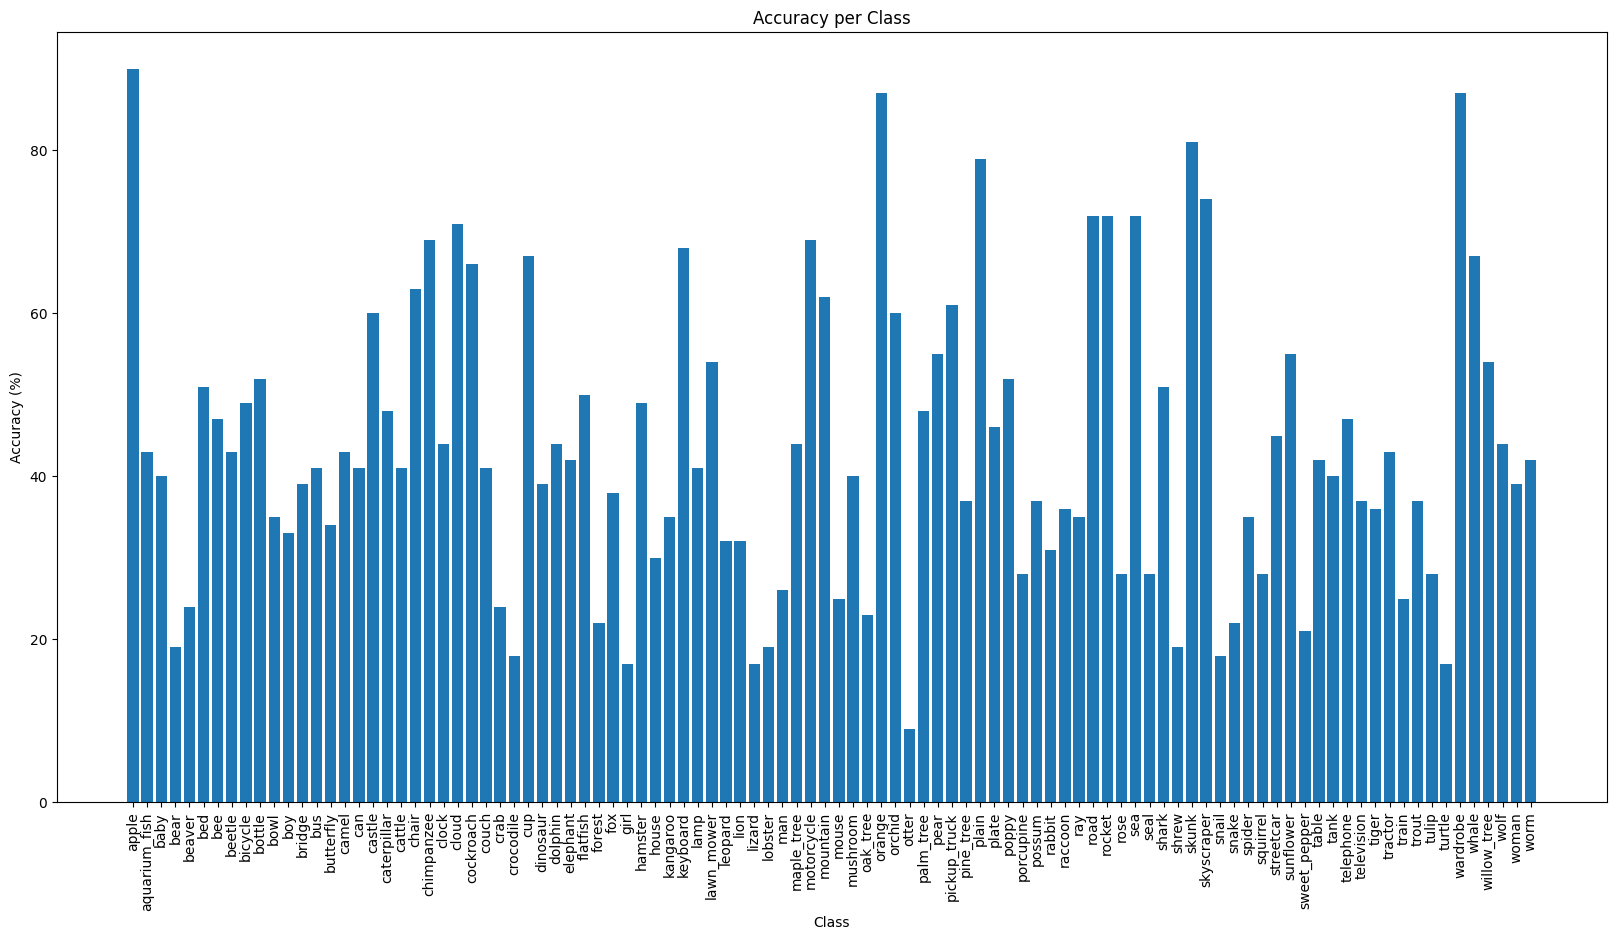

apple: 90.00%
aquarium_fish: 43.00%
baby: 40.00%
bear: 19.00%
beaver: 24.00%
bed: 51.00%
bee: 47.00%
beetle: 43.00%
bicycle: 49.00%
bottle: 52.00%
bowl: 35.00%
boy: 33.00%
bridge: 39.00%
bus: 41.00%
butterfly: 34.00%
camel: 43.00%
can: 41.00%
castle: 60.00%
caterpillar: 48.00%
cattle: 41.00%
chair: 63.00%
chimpanzee: 69.00%
clock: 44.00%
cloud: 71.00%
cockroach: 66.00%
couch: 41.00%
crab: 24.00%
crocodile: 18.00%
cup: 67.00%
dinosaur: 39.00%
dolphin: 44.00%
elephant: 42.00%
flatfish: 50.00%
forest: 22.00%
fox: 38.00%
girl: 17.00%
hamster: 49.00%
house: 30.00%
kangaroo: 35.00%
keyboard: 68.00%
lamp: 41.00%
lawn_mower: 54.00%
leopard: 32.00%
lion: 32.00%
lizard: 17.00%
lobster: 19.00%
man: 26.00%
maple_tree: 44.00%
motorcycle: 69.00%
mountain: 62.00%
mouse: 25.00%
mushroom: 40.00%
oak_tree: 23.00%
orange: 87.00%
orchid: 60.00%
otter: 9.00%
palm_tree: 48.00%
pear: 55.00%
pickup_truck: 61.00%
pine_tree: 37.00%
plain: 79.00%
plate: 46.00%
poppy: 52.00%
porcupine: 28.00%
possum: 37.00%
rabbi

In [14]:
# 모델 불러오기
loaded_model = load_model('./model/cifar100_model.pth')

# 평가
test_transforms = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])
_, test_loader = load_data(None, test_transforms)
evaluate_model(loaded_model, test_loader)

/hdd1/iknow/anaconda3/envs/simclr/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/hdd1/iknow/anaconda3/envs/simclr/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_524507/3630220103.py:115: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/bl

Files already downloaded and verified
Files already downloaded and verified
테스트 정확도: 21.03%


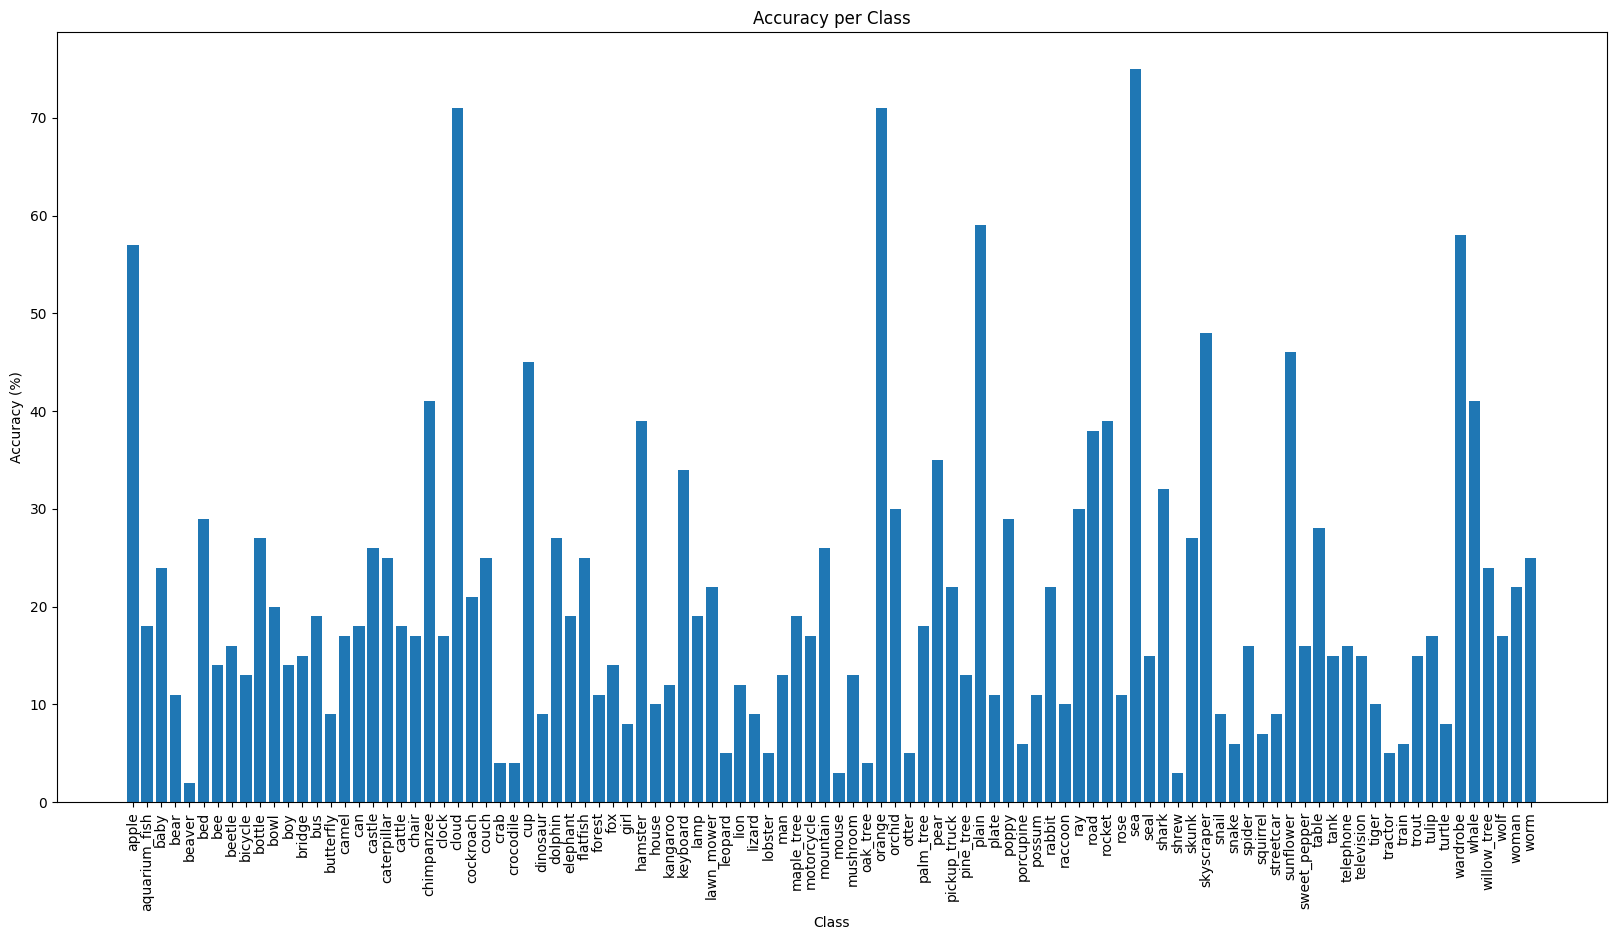

apple: 57.00%
aquarium_fish: 18.00%
baby: 24.00%
bear: 11.00%
beaver: 2.00%
bed: 29.00%
bee: 14.00%
beetle: 16.00%
bicycle: 13.00%
bottle: 27.00%
bowl: 20.00%
boy: 14.00%
bridge: 15.00%
bus: 19.00%
butterfly: 9.00%
camel: 17.00%
can: 18.00%
castle: 26.00%
caterpillar: 25.00%
cattle: 18.00%
chair: 17.00%
chimpanzee: 41.00%
clock: 17.00%
cloud: 71.00%
cockroach: 21.00%
couch: 25.00%
crab: 4.00%
crocodile: 4.00%
cup: 45.00%
dinosaur: 9.00%
dolphin: 27.00%
elephant: 19.00%
flatfish: 25.00%
forest: 11.00%
fox: 14.00%
girl: 8.00%
hamster: 39.00%
house: 10.00%
kangaroo: 12.00%
keyboard: 34.00%
lamp: 19.00%
lawn_mower: 22.00%
leopard: 5.00%
lion: 12.00%
lizard: 9.00%
lobster: 5.00%
man: 13.00%
maple_tree: 19.00%
motorcycle: 17.00%
mountain: 26.00%
mouse: 3.00%
mushroom: 13.00%
oak_tree: 4.00%
orange: 71.00%
orchid: 30.00%
otter: 5.00%
palm_tree: 18.00%
pear: 35.00%
pickup_truck: 22.00%
pine_tree: 13.00%
plain: 59.00%
plate: 11.00%
poppy: 29.00%
porcupine: 6.00%
possum: 11.00%
rabbit: 22.00%
ra

In [13]:
loaded_model = load_model('./model/cifar100_model.pth')

# Crop
test_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

_, test_loader = load_data(None, test_transforms)
evaluate_model(loaded_model, test_loader)

/tmp/ipykernel_524507/3630220103.py:115: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(filepath))


Files already downloaded and verified
Files already downloaded and verified
테스트 정확도: 29.50%


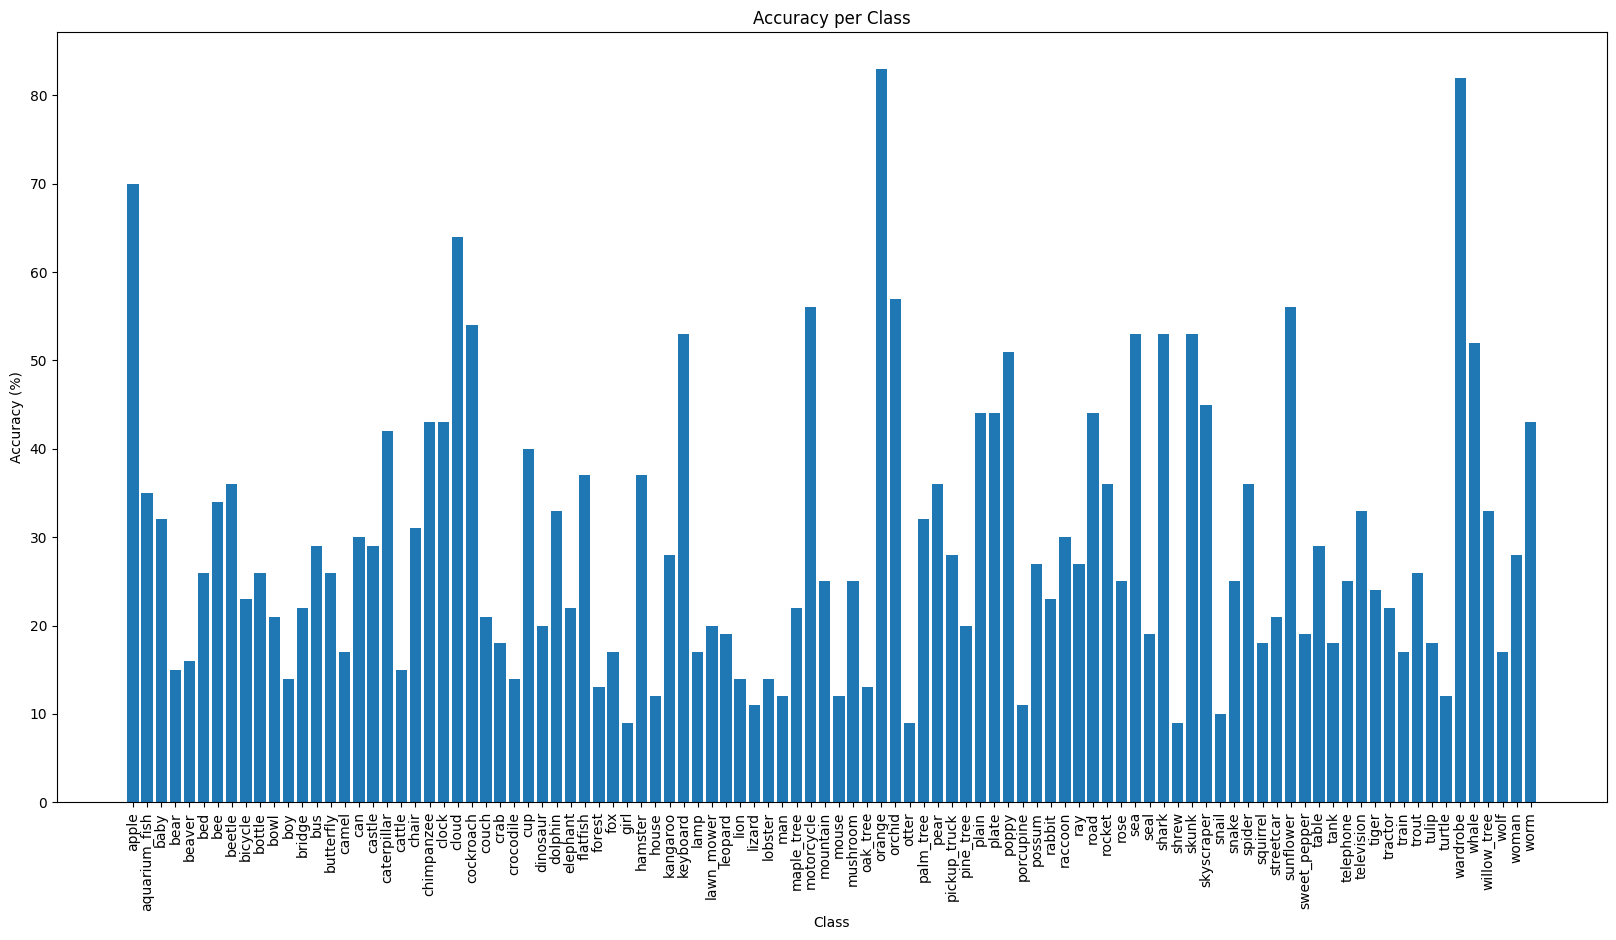

apple: 70.00%
aquarium_fish: 35.00%
baby: 32.00%
bear: 15.00%
beaver: 16.00%
bed: 26.00%
bee: 34.00%
beetle: 36.00%
bicycle: 23.00%
bottle: 26.00%
bowl: 21.00%
boy: 14.00%
bridge: 22.00%
bus: 29.00%
butterfly: 26.00%
camel: 17.00%
can: 30.00%
castle: 29.00%
caterpillar: 42.00%
cattle: 15.00%
chair: 31.00%
chimpanzee: 43.00%
clock: 43.00%
cloud: 64.00%
cockroach: 54.00%
couch: 21.00%
crab: 18.00%
crocodile: 14.00%
cup: 40.00%
dinosaur: 20.00%
dolphin: 33.00%
elephant: 22.00%
flatfish: 37.00%
forest: 13.00%
fox: 17.00%
girl: 9.00%
hamster: 37.00%
house: 12.00%
kangaroo: 28.00%
keyboard: 53.00%
lamp: 17.00%
lawn_mower: 20.00%
leopard: 19.00%
lion: 14.00%
lizard: 11.00%
lobster: 14.00%
man: 12.00%
maple_tree: 22.00%
motorcycle: 56.00%
mountain: 25.00%
mouse: 12.00%
mushroom: 25.00%
oak_tree: 13.00%
orange: 83.00%
orchid: 57.00%
otter: 9.00%
palm_tree: 32.00%
pear: 36.00%
pickup_truck: 28.00%
pine_tree: 20.00%
plain: 44.00%
plate: 44.00%
poppy: 51.00%
porcupine: 11.00%
possum: 27.00%
rabbit

In [16]:
loaded_model = load_model('./model/cifar100_model.pth')

# Flip
test_transforms = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

_, test_loader = load_data(None, test_transforms)
evaluate_model(loaded_model, test_loader)

/hdd1/iknow/anaconda3/envs/simclr/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/hdd1/iknow/anaconda3/envs/simclr/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_524507/3630220103.py:115: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/bl

Files already downloaded and verified
Files already downloaded and verified
테스트 정확도: 19.65%


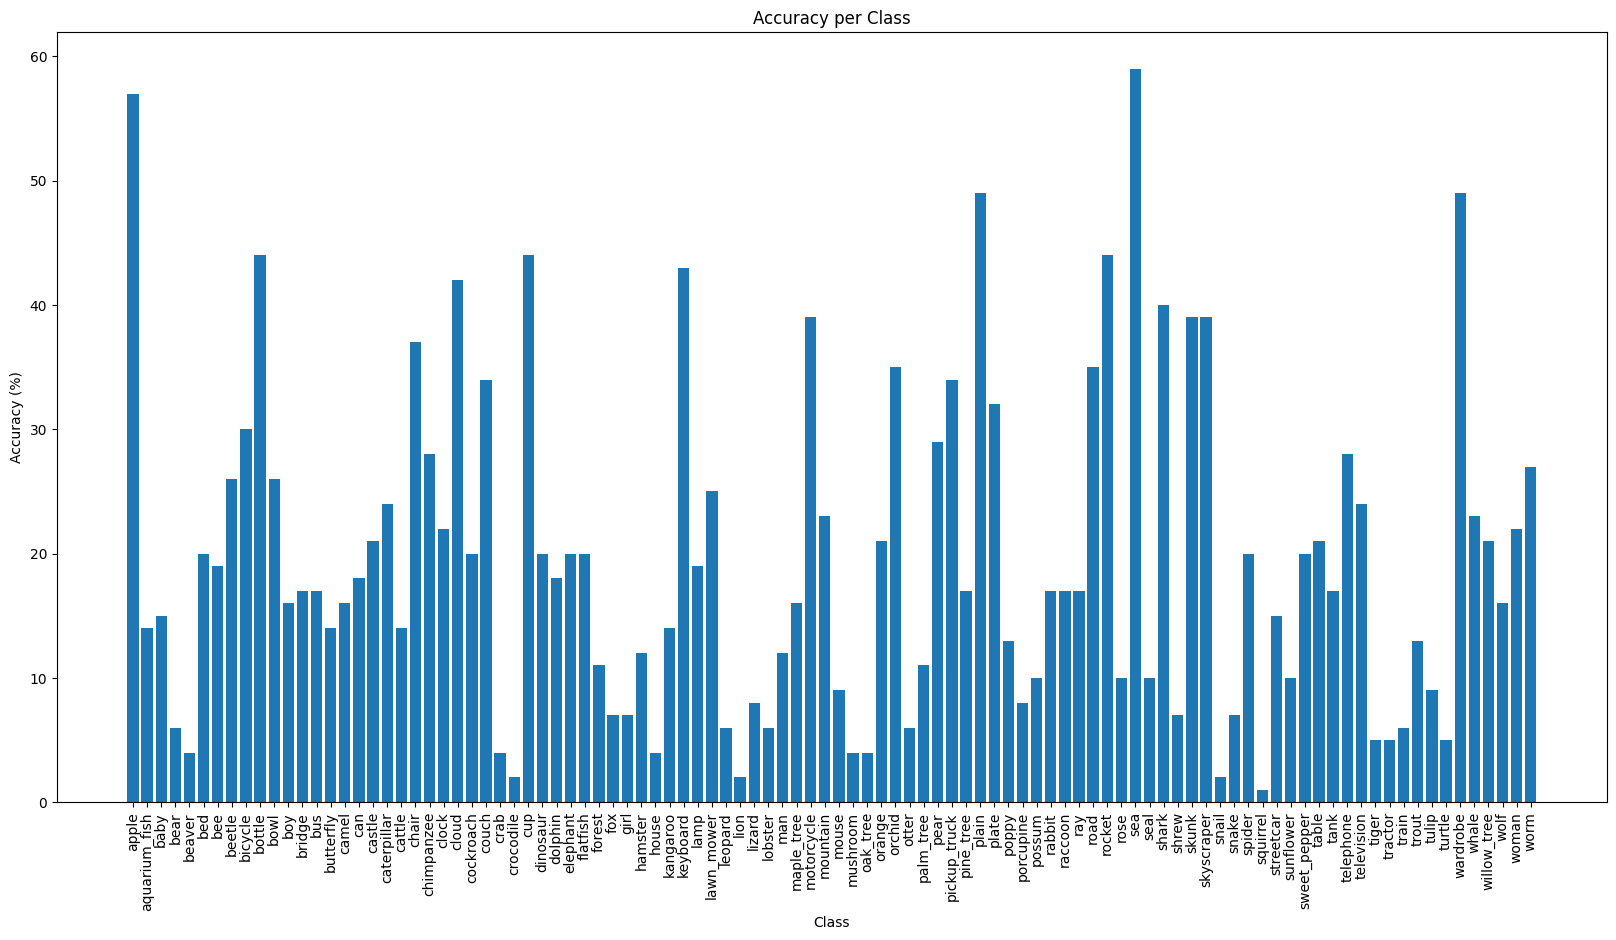

apple: 57.00%
aquarium_fish: 14.00%
baby: 15.00%
bear: 6.00%
beaver: 4.00%
bed: 20.00%
bee: 19.00%
beetle: 26.00%
bicycle: 30.00%
bottle: 44.00%
bowl: 26.00%
boy: 16.00%
bridge: 17.00%
bus: 17.00%
butterfly: 14.00%
camel: 16.00%
can: 18.00%
castle: 21.00%
caterpillar: 24.00%
cattle: 14.00%
chair: 37.00%
chimpanzee: 28.00%
clock: 22.00%
cloud: 42.00%
cockroach: 20.00%
couch: 34.00%
crab: 4.00%
crocodile: 2.00%
cup: 44.00%
dinosaur: 20.00%
dolphin: 18.00%
elephant: 20.00%
flatfish: 20.00%
forest: 11.00%
fox: 7.00%
girl: 7.00%
hamster: 12.00%
house: 4.00%
kangaroo: 14.00%
keyboard: 43.00%
lamp: 19.00%
lawn_mower: 25.00%
leopard: 6.00%
lion: 2.00%
lizard: 8.00%
lobster: 6.00%
man: 12.00%
maple_tree: 16.00%
motorcycle: 39.00%
mountain: 23.00%
mouse: 9.00%
mushroom: 4.00%
oak_tree: 4.00%
orange: 21.00%
orchid: 35.00%
otter: 6.00%
palm_tree: 11.00%
pear: 29.00%
pickup_truck: 34.00%
pine_tree: 17.00%
plain: 49.00%
plate: 32.00%
poppy: 13.00%
porcupine: 8.00%
possum: 10.00%
rabbit: 17.00%
racco

In [17]:
loaded_model = load_model('./model/cifar100_model.pth')

# Color_jitter
test_transforms = transforms.Compose([
    transforms.Resize(224),
    transforms.ColorJitter(0.8, 0.8, 0.8, 0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

_, test_loader = load_data(None, test_transforms)
evaluate_model(loaded_model, test_loader)

/hdd1/iknow/anaconda3/envs/simclr/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/hdd1/iknow/anaconda3/envs/simclr/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_524507/3630220103.py:115: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/bl

Files already downloaded and verified
Files already downloaded and verified
테스트 정확도: 24.18%


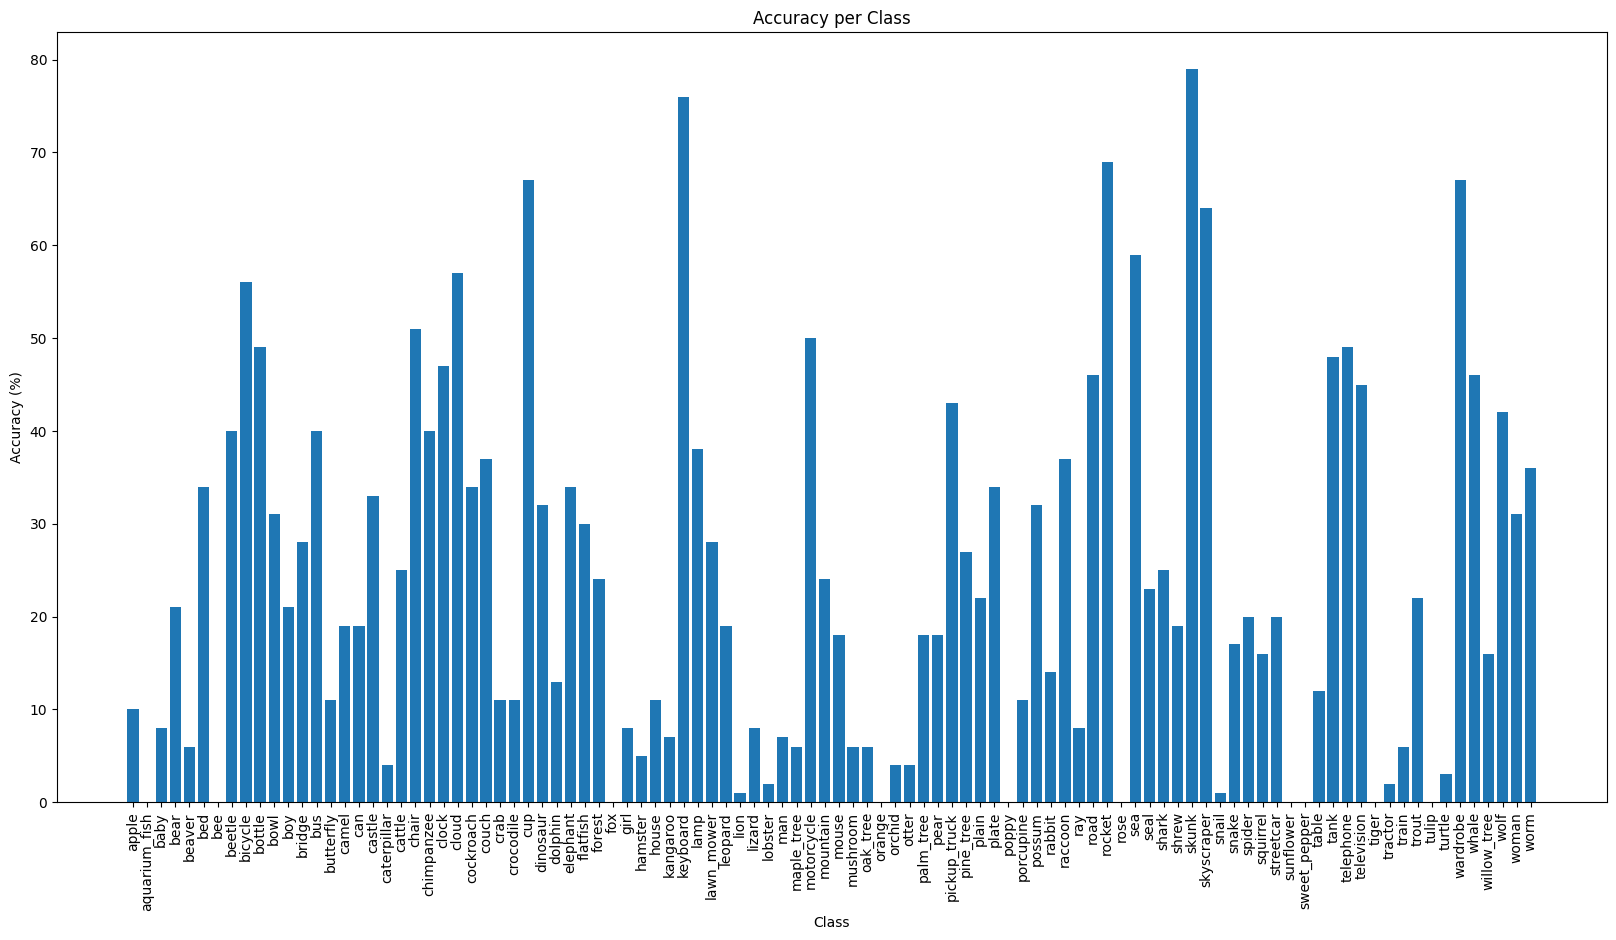

apple: 10.00%
aquarium_fish: 0.00%
baby: 8.00%
bear: 21.00%
beaver: 6.00%
bed: 34.00%
bee: 0.00%
beetle: 40.00%
bicycle: 56.00%
bottle: 49.00%
bowl: 31.00%
boy: 21.00%
bridge: 28.00%
bus: 40.00%
butterfly: 11.00%
camel: 19.00%
can: 19.00%
castle: 33.00%
caterpillar: 4.00%
cattle: 25.00%
chair: 51.00%
chimpanzee: 40.00%
clock: 47.00%
cloud: 57.00%
cockroach: 34.00%
couch: 37.00%
crab: 11.00%
crocodile: 11.00%
cup: 67.00%
dinosaur: 32.00%
dolphin: 13.00%
elephant: 34.00%
flatfish: 30.00%
forest: 24.00%
fox: 0.00%
girl: 8.00%
hamster: 5.00%
house: 11.00%
kangaroo: 7.00%
keyboard: 76.00%
lamp: 38.00%
lawn_mower: 28.00%
leopard: 19.00%
lion: 1.00%
lizard: 8.00%
lobster: 2.00%
man: 7.00%
maple_tree: 6.00%
motorcycle: 50.00%
mountain: 24.00%
mouse: 18.00%
mushroom: 6.00%
oak_tree: 6.00%
orange: 0.00%
orchid: 4.00%
otter: 4.00%
palm_tree: 18.00%
pear: 18.00%
pickup_truck: 43.00%
pine_tree: 27.00%
plain: 22.00%
plate: 34.00%
poppy: 0.00%
porcupine: 11.00%
possum: 32.00%
rabbit: 14.00%
raccoon: 

In [18]:
loaded_model = load_model('./model/cifar100_model.pth')

# Grayscale
test_transforms = transforms.Compose([
    transforms.Resize(224),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

_, test_loader = load_data(None, test_transforms)
evaluate_model(loaded_model, test_loader)

/hdd1/iknow/anaconda3/envs/simclr/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/hdd1/iknow/anaconda3/envs/simclr/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_524507/3630220103.py:115: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/bl

Files already downloaded and verified
Files already downloaded and verified
테스트 정확도: 31.55%


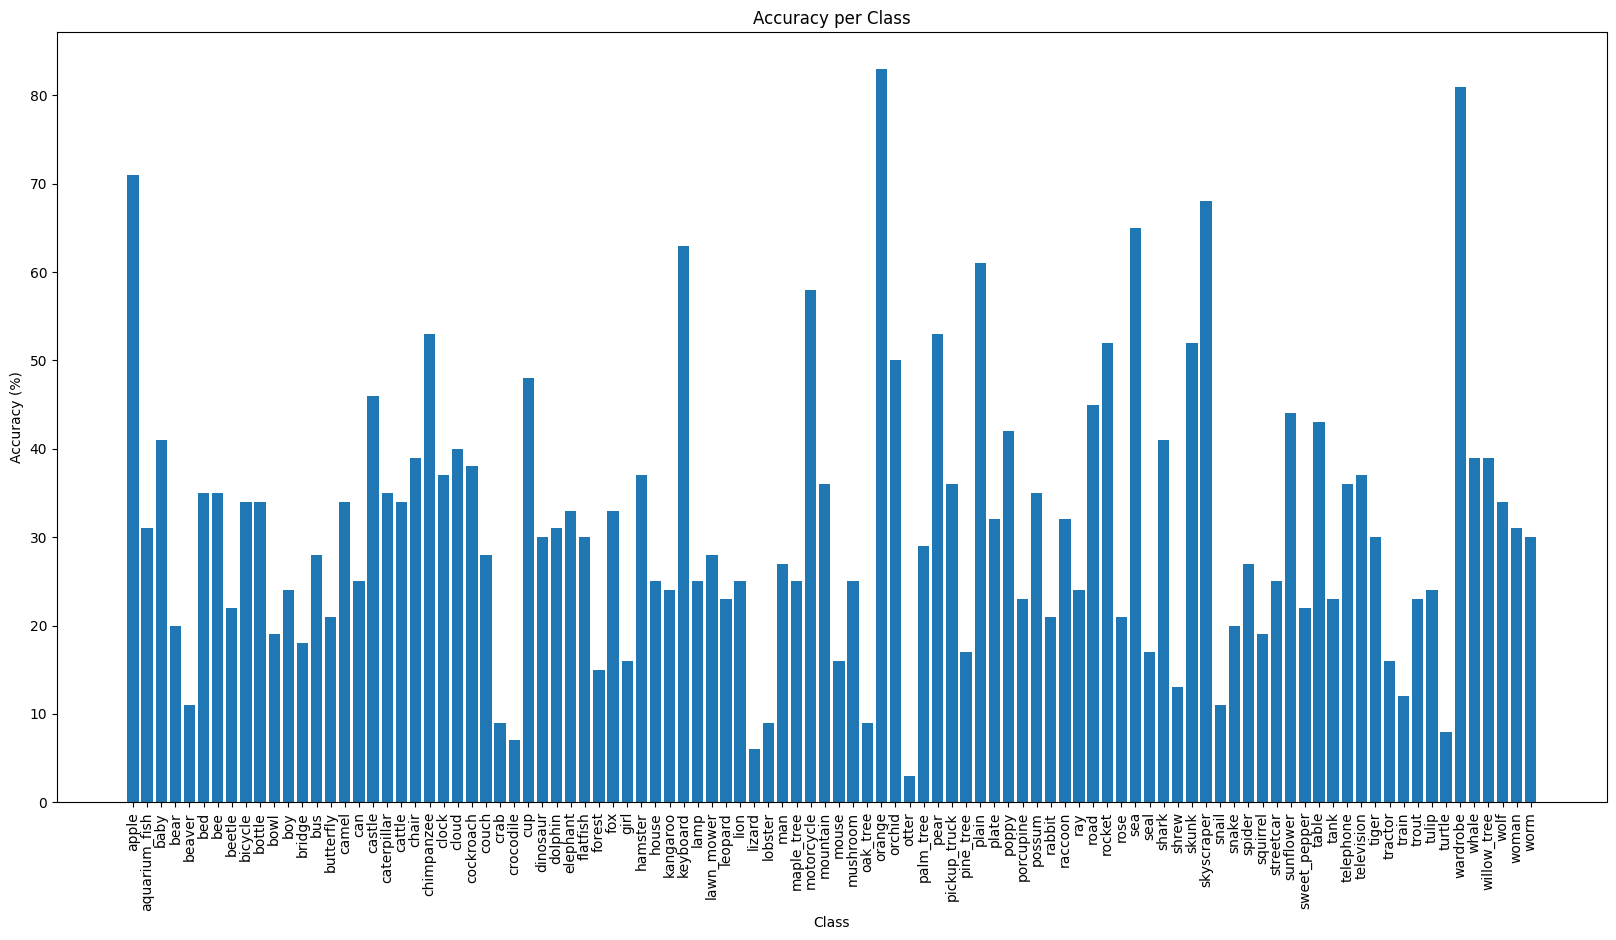

apple: 71.00%
aquarium_fish: 31.00%
baby: 41.00%
bear: 20.00%
beaver: 11.00%
bed: 35.00%
bee: 35.00%
beetle: 22.00%
bicycle: 34.00%
bottle: 34.00%
bowl: 19.00%
boy: 24.00%
bridge: 18.00%
bus: 28.00%
butterfly: 21.00%
camel: 34.00%
can: 25.00%
castle: 46.00%
caterpillar: 35.00%
cattle: 34.00%
chair: 39.00%
chimpanzee: 53.00%
clock: 37.00%
cloud: 40.00%
cockroach: 38.00%
couch: 28.00%
crab: 9.00%
crocodile: 7.00%
cup: 48.00%
dinosaur: 30.00%
dolphin: 31.00%
elephant: 33.00%
flatfish: 30.00%
forest: 15.00%
fox: 33.00%
girl: 16.00%
hamster: 37.00%
house: 25.00%
kangaroo: 24.00%
keyboard: 63.00%
lamp: 25.00%
lawn_mower: 28.00%
leopard: 23.00%
lion: 25.00%
lizard: 6.00%
lobster: 9.00%
man: 27.00%
maple_tree: 25.00%
motorcycle: 58.00%
mountain: 36.00%
mouse: 16.00%
mushroom: 25.00%
oak_tree: 9.00%
orange: 83.00%
orchid: 50.00%
otter: 3.00%
palm_tree: 29.00%
pear: 53.00%
pickup_truck: 36.00%
pine_tree: 17.00%
plain: 61.00%
plate: 32.00%
poppy: 42.00%
porcupine: 23.00%
possum: 35.00%
rabbit: 21

In [19]:
loaded_model = load_model('./model/cifar100_model.pth')

# Translation
test_transforms = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomAffine(0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

_, test_loader = load_data(None, test_transforms)
evaluate_model(loaded_model, test_loader)

/hdd1/iknow/anaconda3/envs/simclr/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/hdd1/iknow/anaconda3/envs/simclr/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_524507/3630220103.py:115: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/bl

Files already downloaded and verified
Files already downloaded and verified
테스트 정확도: 40.81%


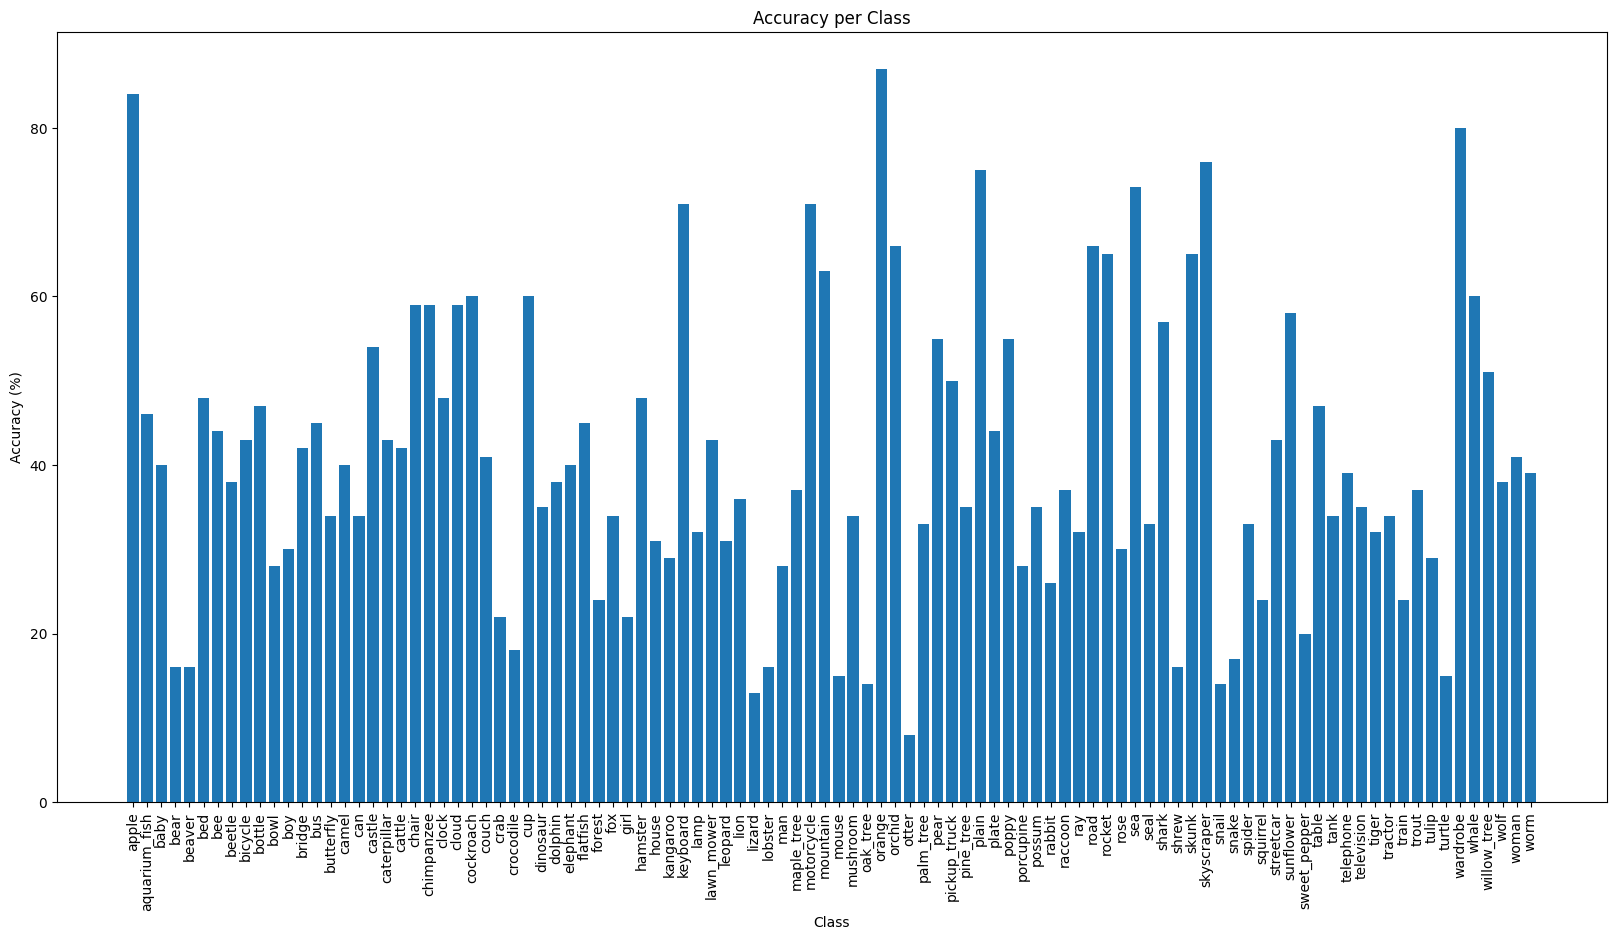

apple: 84.00%
aquarium_fish: 46.00%
baby: 40.00%
bear: 16.00%
beaver: 16.00%
bed: 48.00%
bee: 44.00%
beetle: 38.00%
bicycle: 43.00%
bottle: 47.00%
bowl: 28.00%
boy: 30.00%
bridge: 42.00%
bus: 45.00%
butterfly: 34.00%
camel: 40.00%
can: 34.00%
castle: 54.00%
caterpillar: 43.00%
cattle: 42.00%
chair: 59.00%
chimpanzee: 59.00%
clock: 48.00%
cloud: 59.00%
cockroach: 60.00%
couch: 41.00%
crab: 22.00%
crocodile: 18.00%
cup: 60.00%
dinosaur: 35.00%
dolphin: 38.00%
elephant: 40.00%
flatfish: 45.00%
forest: 24.00%
fox: 34.00%
girl: 22.00%
hamster: 48.00%
house: 31.00%
kangaroo: 29.00%
keyboard: 71.00%
lamp: 32.00%
lawn_mower: 43.00%
leopard: 31.00%
lion: 36.00%
lizard: 13.00%
lobster: 16.00%
man: 28.00%
maple_tree: 37.00%
motorcycle: 71.00%
mountain: 63.00%
mouse: 15.00%
mushroom: 34.00%
oak_tree: 14.00%
orange: 87.00%
orchid: 66.00%
otter: 8.00%
palm_tree: 33.00%
pear: 55.00%
pickup_truck: 50.00%
pine_tree: 35.00%
plain: 75.00%
plate: 44.00%
poppy: 55.00%
porcupine: 28.00%
possum: 35.00%
rabbi

In [20]:
loaded_model = load_model('./model/cifar100_model.pth')

# Shearing
test_transforms = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomAffine(degrees=0, shear=10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

_, test_loader = load_data(None, test_transforms)
evaluate_model(loaded_model, test_loader)

/hdd1/iknow/anaconda3/envs/simclr/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/hdd1/iknow/anaconda3/envs/simclr/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_524507/3630220103.py:115: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/bl

Files already downloaded and verified
Files already downloaded and verified
테스트 정확도: 14.87%


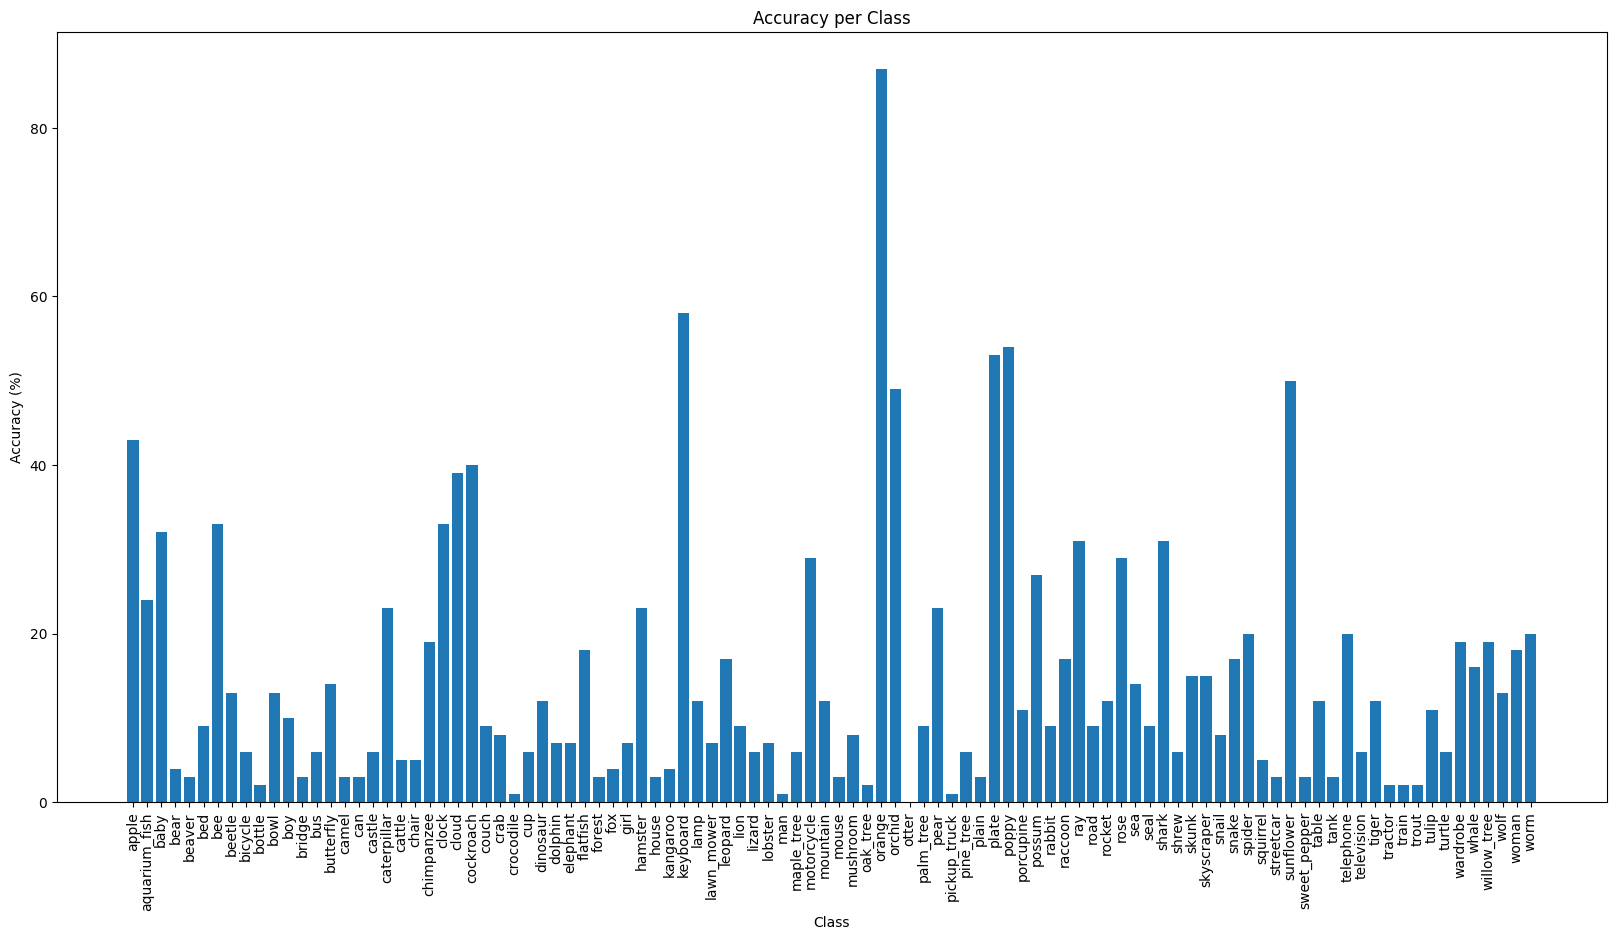

apple: 43.00%
aquarium_fish: 24.00%
baby: 32.00%
bear: 4.00%
beaver: 3.00%
bed: 9.00%
bee: 33.00%
beetle: 13.00%
bicycle: 6.00%
bottle: 2.00%
bowl: 13.00%
boy: 10.00%
bridge: 3.00%
bus: 6.00%
butterfly: 14.00%
camel: 3.00%
can: 3.00%
castle: 6.00%
caterpillar: 23.00%
cattle: 5.00%
chair: 5.00%
chimpanzee: 19.00%
clock: 33.00%
cloud: 39.00%
cockroach: 40.00%
couch: 9.00%
crab: 8.00%
crocodile: 1.00%
cup: 6.00%
dinosaur: 12.00%
dolphin: 7.00%
elephant: 7.00%
flatfish: 18.00%
forest: 3.00%
fox: 4.00%
girl: 7.00%
hamster: 23.00%
house: 3.00%
kangaroo: 4.00%
keyboard: 58.00%
lamp: 12.00%
lawn_mower: 7.00%
leopard: 17.00%
lion: 9.00%
lizard: 6.00%
lobster: 7.00%
man: 1.00%
maple_tree: 6.00%
motorcycle: 29.00%
mountain: 12.00%
mouse: 3.00%
mushroom: 8.00%
oak_tree: 2.00%
orange: 87.00%
orchid: 49.00%
otter: 0.00%
palm_tree: 9.00%
pear: 23.00%
pickup_truck: 1.00%
pine_tree: 6.00%
plain: 3.00%
plate: 53.00%
poppy: 54.00%
porcupine: 11.00%
possum: 27.00%
rabbit: 9.00%
raccoon: 17.00%
ray: 31.00%

In [21]:
loaded_model = load_model('./model/cifar100_model.pth')

# Rotation
test_transforms = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomRotation(degrees=180),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

_, test_loader = load_data(None, test_transforms)
evaluate_model(loaded_model, test_loader)

/hdd1/iknow/anaconda3/envs/simclr/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/hdd1/iknow/anaconda3/envs/simclr/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_524507/3630220103.py:115: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/bl

Files already downloaded and verified
Files already downloaded and verified
테스트 정확도: 30.66%


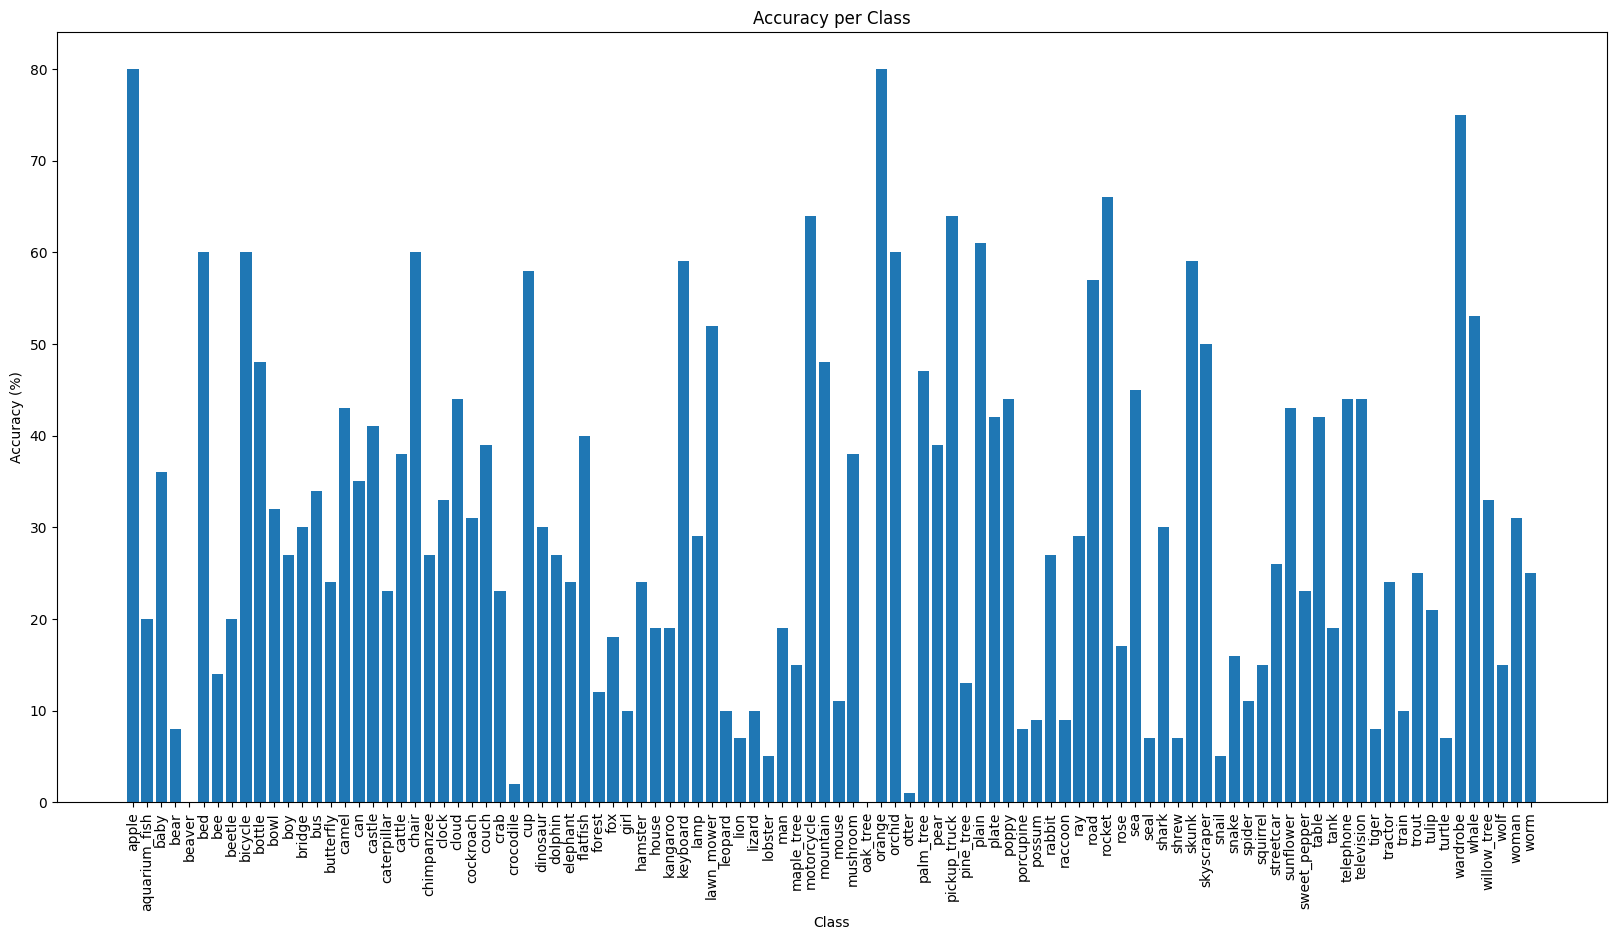

apple: 80.00%
aquarium_fish: 20.00%
baby: 36.00%
bear: 8.00%
beaver: 0.00%
bed: 60.00%
bee: 14.00%
beetle: 20.00%
bicycle: 60.00%
bottle: 48.00%
bowl: 32.00%
boy: 27.00%
bridge: 30.00%
bus: 34.00%
butterfly: 24.00%
camel: 43.00%
can: 35.00%
castle: 41.00%
caterpillar: 23.00%
cattle: 38.00%
chair: 60.00%
chimpanzee: 27.00%
clock: 33.00%
cloud: 44.00%
cockroach: 31.00%
couch: 39.00%
crab: 23.00%
crocodile: 2.00%
cup: 58.00%
dinosaur: 30.00%
dolphin: 27.00%
elephant: 24.00%
flatfish: 40.00%
forest: 12.00%
fox: 18.00%
girl: 10.00%
hamster: 24.00%
house: 19.00%
kangaroo: 19.00%
keyboard: 59.00%
lamp: 29.00%
lawn_mower: 52.00%
leopard: 10.00%
lion: 7.00%
lizard: 10.00%
lobster: 5.00%
man: 19.00%
maple_tree: 15.00%
motorcycle: 64.00%
mountain: 48.00%
mouse: 11.00%
mushroom: 38.00%
oak_tree: 0.00%
orange: 80.00%
orchid: 60.00%
otter: 1.00%
palm_tree: 47.00%
pear: 39.00%
pickup_truck: 64.00%
pine_tree: 13.00%
plain: 61.00%
plate: 42.00%
poppy: 44.00%
porcupine: 8.00%
possum: 9.00%
rabbit: 27.00

In [22]:
class CenterErasing(object):
    def __init__(self, length):
        self.length = length

    def __call__(self, img):
        h, w = img.size(1), img.size(2)
        y1 = (h - self.length) // 2
        y2 = (h + self.length) // 2
        x1 = (w - self.length) // 2
        x2 = (w + self.length) // 2

        img[:, y1:y2, x1:x2] = 0
        return img

loaded_model = load_model('./model/cifar100_model.pth')

# Cutout
test_transforms = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    CenterErasing(length=56),            
])

_, test_loader = load_data(None, test_transforms)
evaluate_model(loaded_model, test_loader)

/hdd1/iknow/anaconda3/envs/simclr/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/hdd1/iknow/anaconda3/envs/simclr/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_492426/2033247822.py:102: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/bl

Files already downloaded and verified
Files already downloaded and verified
테스트 정확도: 81.60%


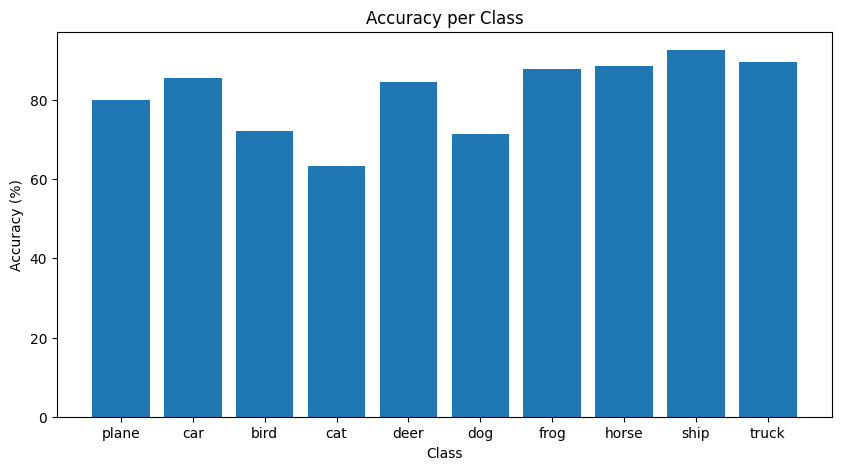

plane: 80.10%
car: 85.60%
bird: 72.20%
cat: 63.30%
deer: 84.60%
dog: 71.50%
frog: 87.90%
horse: 88.60%
ship: 92.60%
truck: 89.60%


In [59]:
loaded_model = load_model('./model/cifar100_model.pth')

# Noise_injection
test_transforms = transforms.Compose([
    transforms.Resize(224),            
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.Lambda(lambda img: img + 0.1 * torch.randn_like(img)),
])

_, test_loader = load_data(None, test_transforms)
evaluate_model(loaded_model, test_loader)

/hdd1/iknow/anaconda3/envs/simclr/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/hdd1/iknow/anaconda3/envs/simclr/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_492426/2033247822.py:102: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/bl

Files already downloaded and verified
Files already downloaded and verified
테스트 정확도: 80.79%


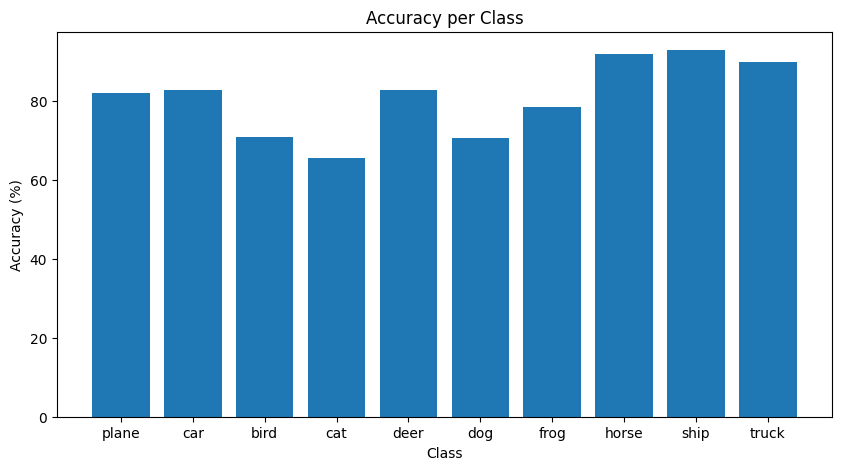

plane: 82.10%
car: 82.90%
bird: 70.80%
cat: 65.60%
deer: 82.70%
dog: 70.50%
frog: 78.40%
horse: 92.00%
ship: 92.90%
truck: 90.00%


In [60]:
loaded_model = load_model('./model/cifar100_model.pth')

# Kernel_filtering
test_transforms = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(9, 11)),
])

_, test_loader = load_data(None, test_transforms)
evaluate_model(loaded_model, test_loader)

/hdd1/iknow/anaconda3/envs/simclr/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/hdd1/iknow/anaconda3/envs/simclr/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_492426/2033247822.py:102: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/bl

Files already downloaded and verified
Files already downloaded and verified
테스트 정확도: 74.50%


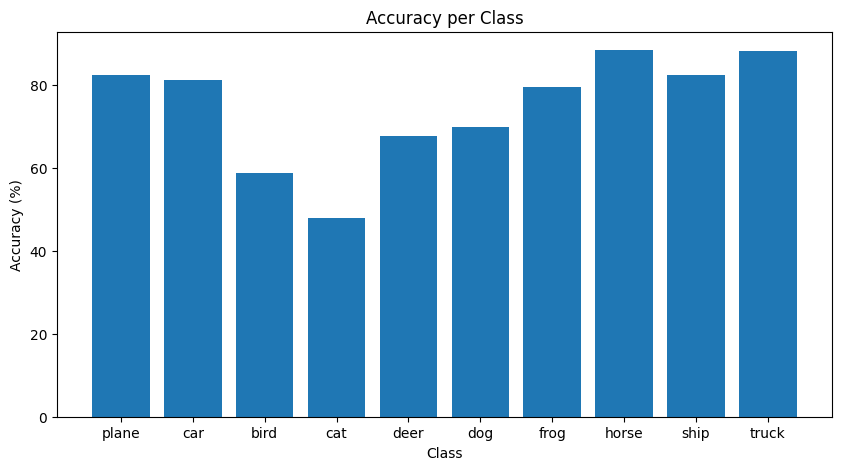

plane: 82.30%
car: 81.00%
bird: 58.70%
cat: 47.80%
deer: 67.50%
dog: 69.70%
frog: 79.40%
horse: 88.30%
ship: 82.20%
truck: 88.10%


In [61]:
loaded_model = load_model('./model/cifar100_model.pth')

# Random_erasing
test_transforms = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.RandomErasing(p=1.0, scale=(0.02, 0.1), ratio=(0.3, 3.3), value='random'),
])

_, test_loader = load_data(None, test_transforms)
evaluate_model(loaded_model, test_loader)